In [1]:
import tensorflow as tf
import sys
import os
import re
sys.path.append('/nas/longleaf/home/siyangj/NiftyNet/')
import niftynet as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import SimpleITK as sitk
import nibabel as nib

INFO:tensorflow:TensorFlow version 1.9.0
CRITICAL:tensorflow:Optional Python module cv2 not found, please install cv2 and retry if the application fails.
INFO:tensorflow:Available Image Loaders:
['nibabel', 'skimage', 'pillow', 'simpleitk', 'dummy'].


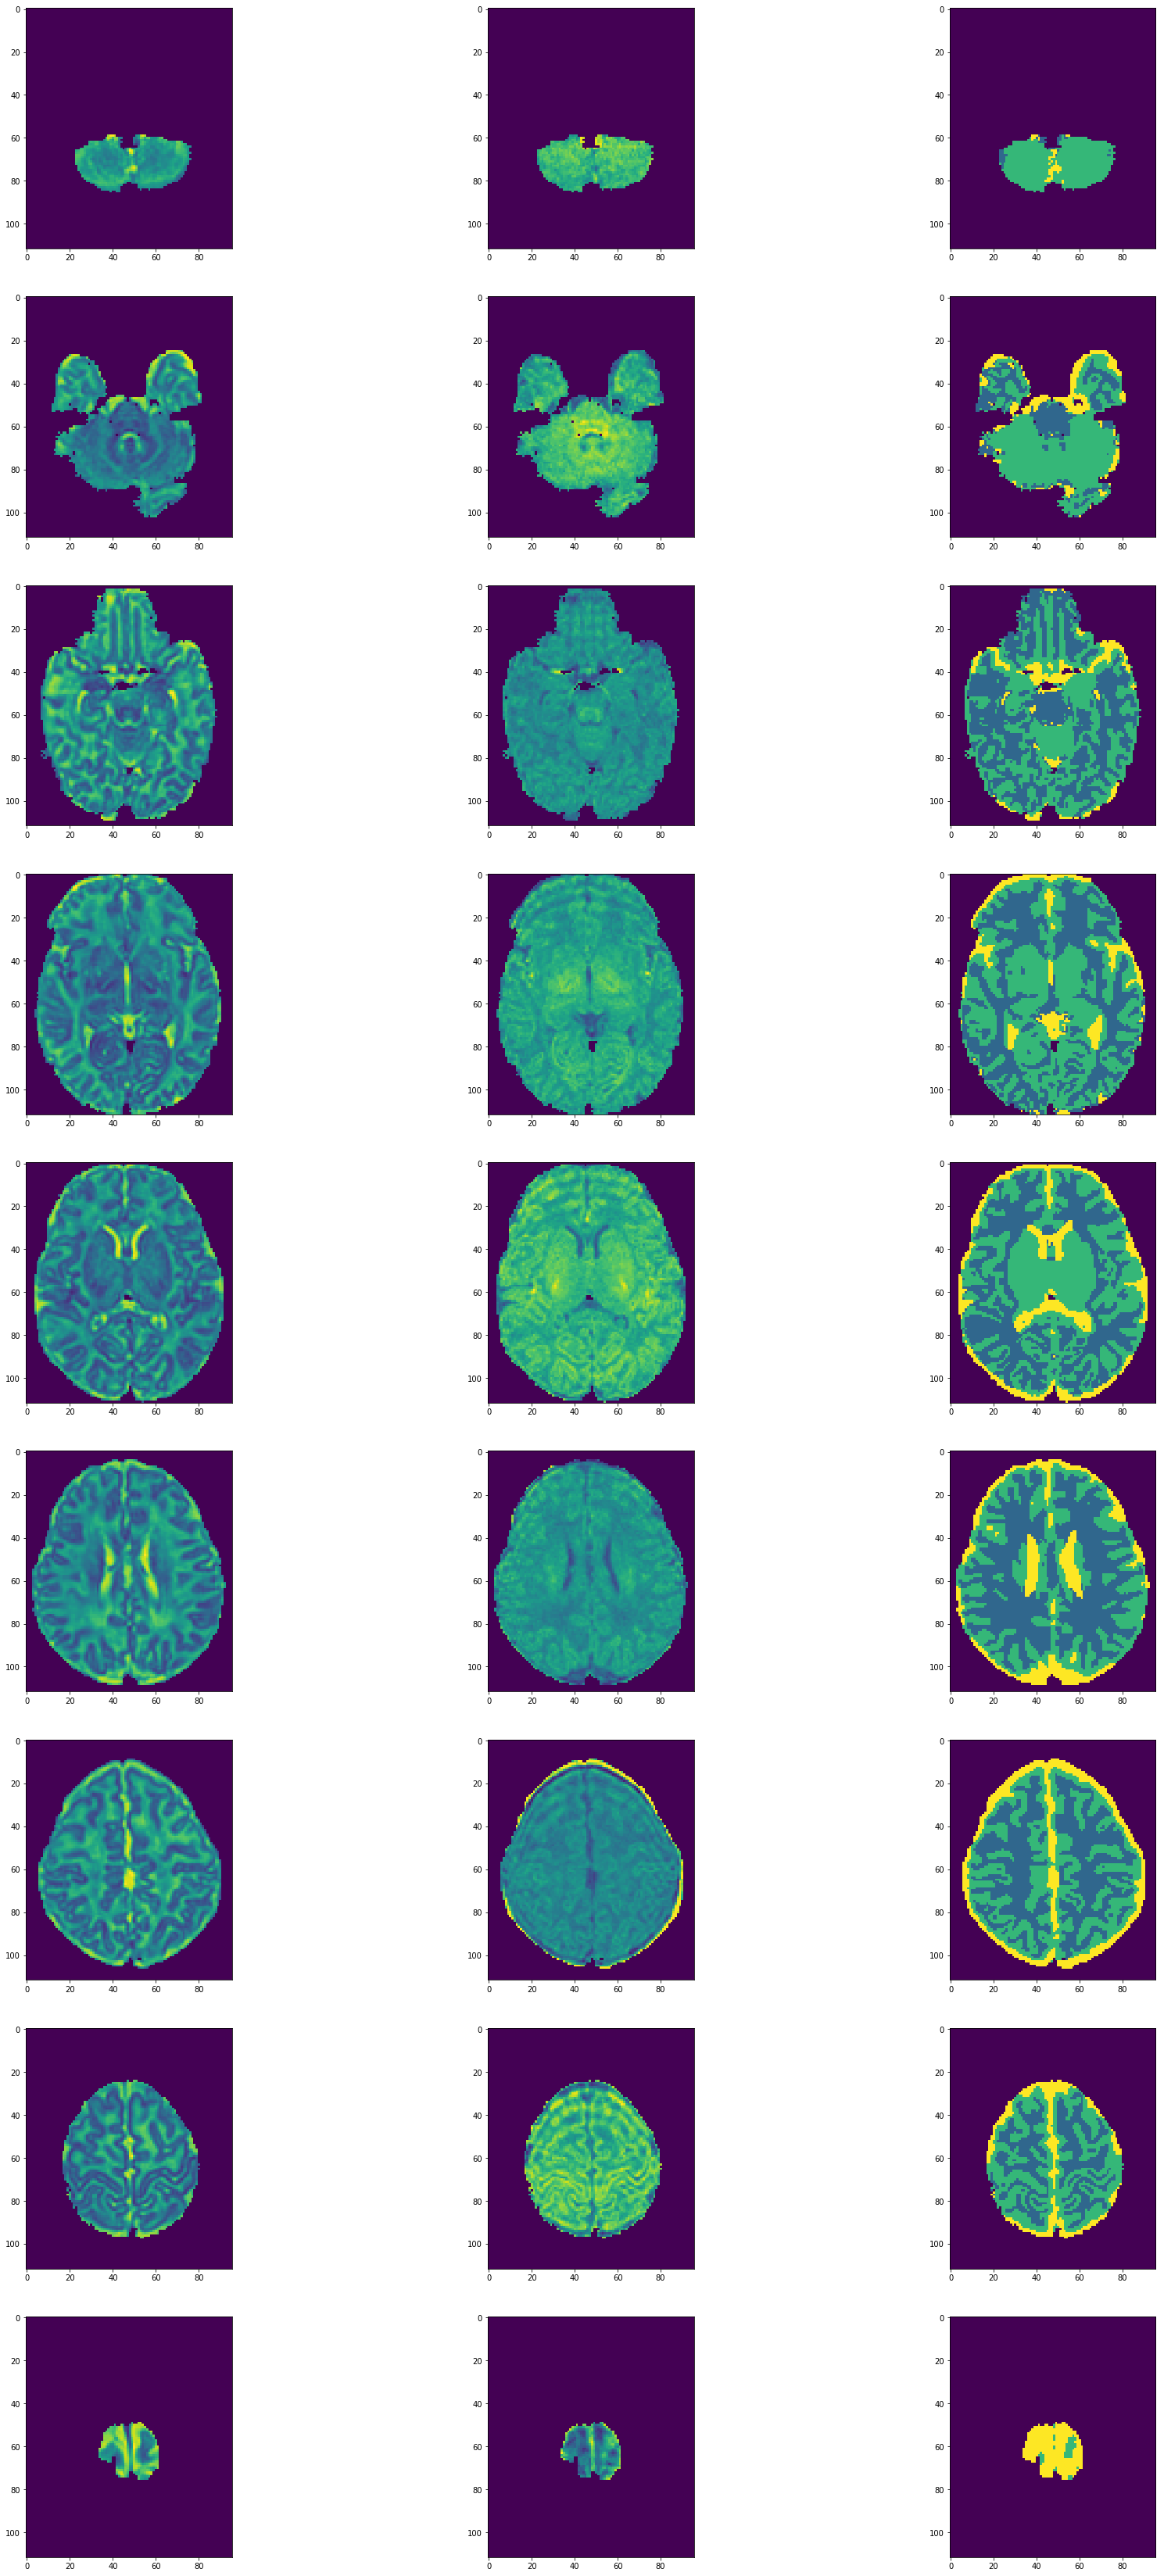

In [4]:
im_name = 'subject-3'

data_folder = '/proj/NIRAL/users/siyangj/myData/BernNet_SwapModality/Train/'

#inf_dir = '10112055_21900_2'
T1_dir = 'T1'
T2_dir = 'T2'

has_ground_truth = False

inf_path = os.path.join(data_folder,im_name,im_name+'-label.nii.gz')
T1_path = os.path.join(data_folder,im_name,im_name+'-T1.nii.gz')
T2_path = os.path.join(data_folder,im_name,im_name+'-T2.nii.gz')

inf = sitk.GetArrayFromImage(sitk.ReadImage(inf_path)).squeeze()
T2 = sitk.GetArrayFromImage(sitk.ReadImage(T2_path)).squeeze()
T1 = sitk.GetArrayFromImage(sitk.ReadImage(T1_path)).squeeze()

if has_ground_truth:
    seg_path = os.path.join(data_folder,seg_dir,im_name+'.nrrd')
    seg = sitk.GetArrayFromImage(sitk.ReadImage(seg_path)).squeeze()

i = 70
js = [10,20,30,40,50,60,70,80,90]
jlength = len(js)

im_per_row = 4 if has_ground_truth else 3

f,axes = plt.subplots(jlength,im_per_row,figsize=(30,60))

for i in np.arange(jlength): 
    axes[i][0].imshow(T1[js[i],:,:])
    axes[i][1].imshow(T2[js[i],:,:])
    axes[i][2].imshow(inf[js[i],:,:])
    if has_ground_truth:
        axes[i][3].imshow(seg[js[i],:,:])

In [11]:
T2.shape

(96, 112, 96)

In [10]:
im_num = np.arange(1,9)
suf1 = ['','-flip']
suf2 = {'-seg':'seg/','-T1-stripped':'T1/','-T2-stripped':'T2/'}
cur_dim = np.array([130,140,120])
tar_dim = np.array([136,144,120])
dif_dim = tar_dim - cur_dim
haf_dim = tar_dim / 2

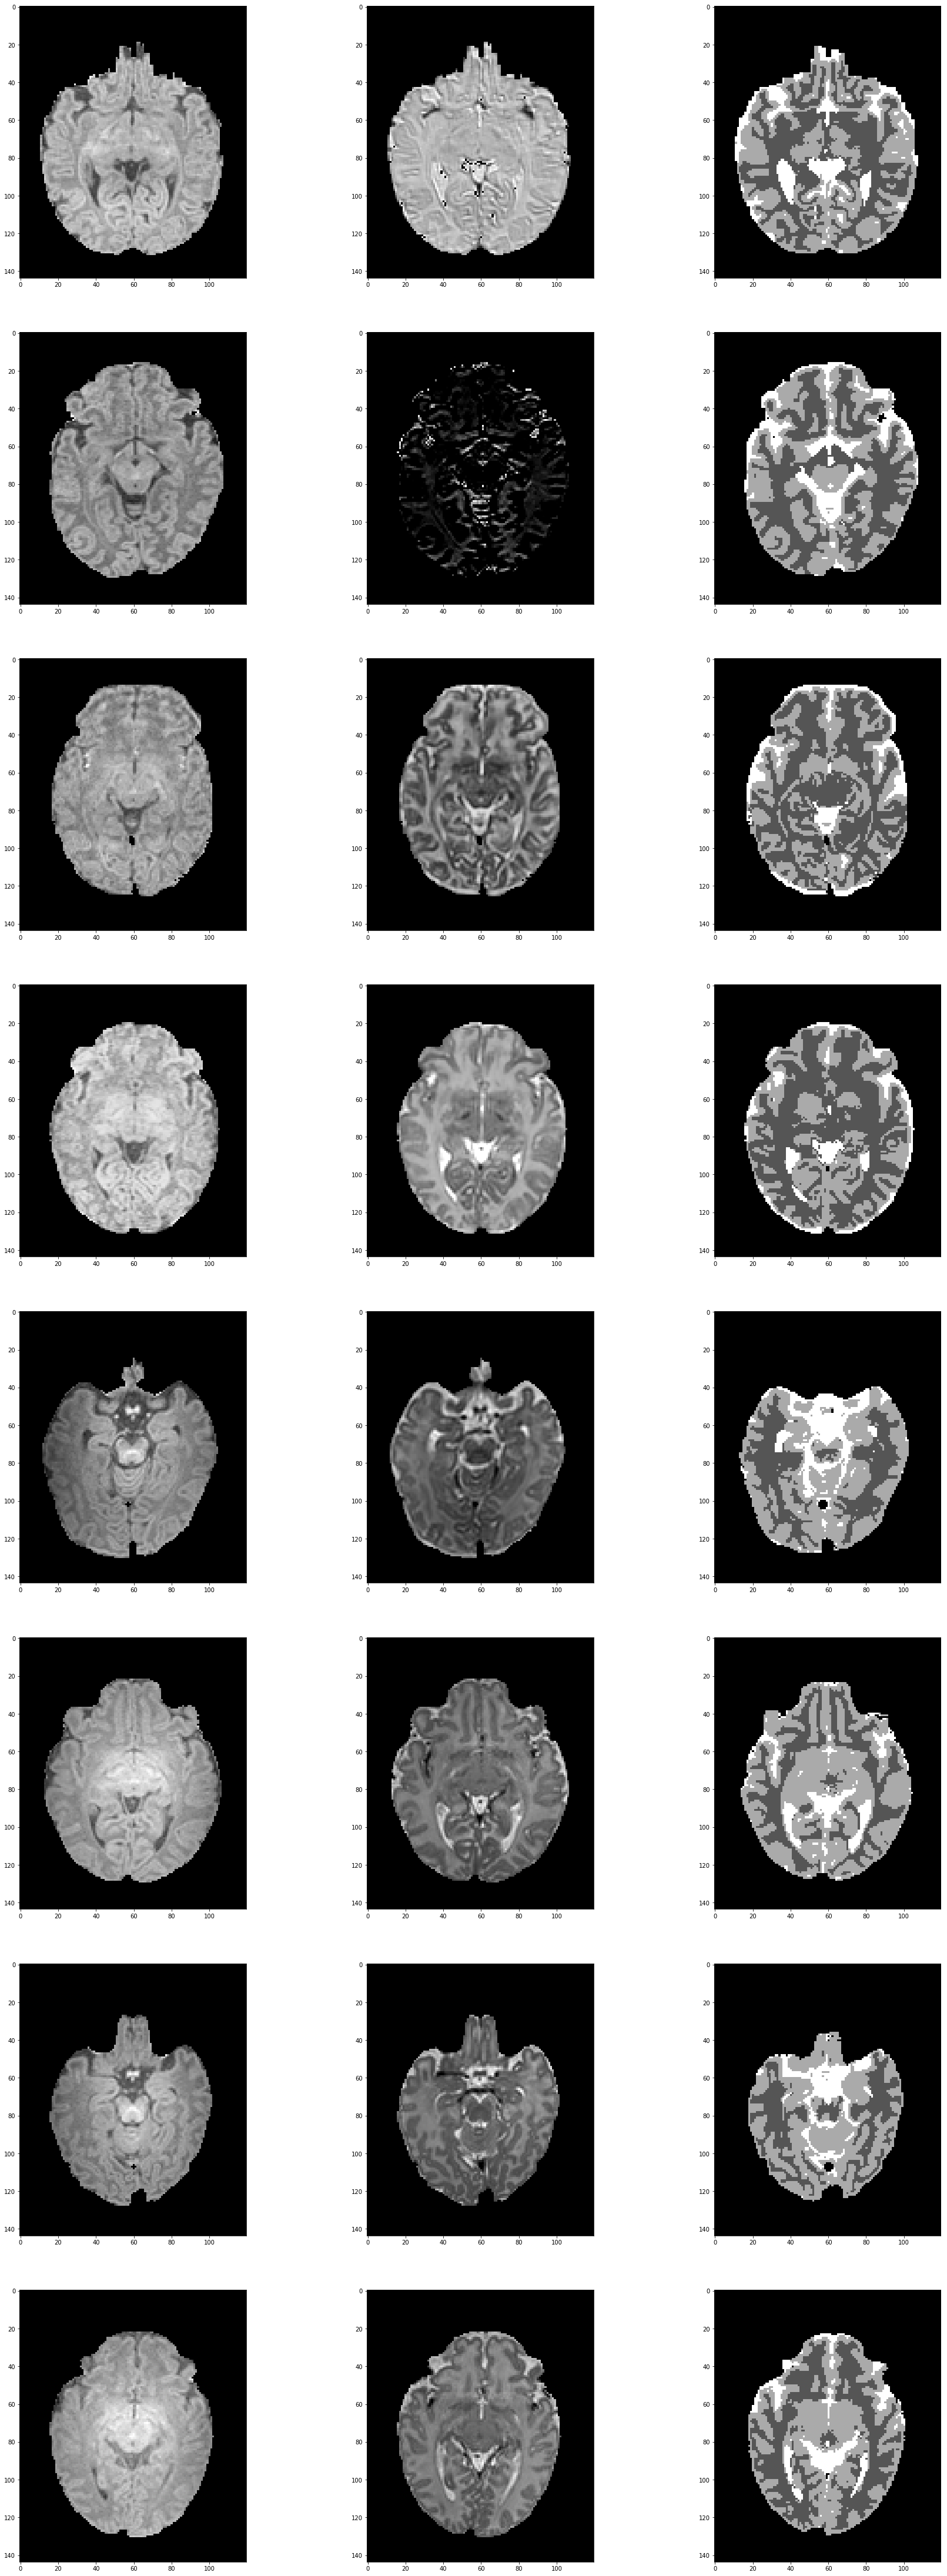

In [5]:
f,axes = plt.subplots(8,3,figsize=(30,80))

slice_num = 60
for i in im_num:
    for s in suf1[0:]:
        im_T1 = sitk.ReadImage(normal_path+'T1/'+str(i)+s+'.nrrd')
        im_T2 = sitk.ReadImage(normal_path+'T2/'+str(i)+s+'.nrrd')
        im_seg = sitk.ReadImage(normal_path+'seg/'+str(i)+s+'.nrrd')
        axes[i-1][0].imshow(sitk.GetArrayFromImage(im_T1)[slice_num,:,:],cmap='gray')
        axes[i-1][1].imshow(sitk.GetArrayFromImage(im_T2)[slice_num,:,:],cmap='gray')
        axes[i-1][2].imshow(sitk.GetArrayFromImage(im_seg)[slice_num,:,:],cmap='gray')

In [5]:
import sys
niftynet_path = '../../'
sys.path.append(niftynet_path)


from niftynet.io.image_reader import ImageReader
from niftynet.contrib.dataset_sampler.sampler_uniform_v2 import UniformSampler
from niftynet.layer.pad import PadLayer
from niftynet.layer.rand_elastic_deform import RandomElasticDeformationLayer
from niftynet.layer.mean_variance_normalisation import MeanVarNormalisationLayer
from niftynet.layer.rand_flip import RandomFlipLayer


def create_image_reader(num_controlpoints, std_deformation_sigma):
    # creating an image reader.
    data_param = \
        {'T1': {'path_to_search': normal_path+'T1/', 
                'filename_contains': '',
                'loader': 'simpleitk'},
         'T2': {'path_to_search': normal_path+'T2/', 
                'filename_contains': '',
                'loader': 'simpleitk'},
         'label': {'path_to_search': normal_path+'seg/', 
                'filename_contains': '',
                'loader': 'simpleitk',
                'interp_order' : 0}
        }
    reader = ImageReader().initialise(data_param)

    #reader.add_preprocessing_layers(MeanVarNormalisationLayer(image_name = 'T1'))
    #reader.add_preprocessing_layers(MeanVarNormalisationLayer(image_name = 'T2'))

    reader.add_preprocessing_layers(PadLayer(
                     image_name=['T1','T2','label'],
                     border=(16,16,16),
                     mode='symmetric'
    )) 

    reader.add_preprocessing_layers(RandomElasticDeformationLayer(
                     num_controlpoints=num_controlpoints,
                     std_deformation_sigma=std_deformation_sigma,
                     proportion_to_augment=1,
                     spatial_rank=2)) 
    
#     reader.add_preprocessing_layers(RandomFlipLayer(
#                  flip_axes=(0,1))) 

    return reader



In [6]:
std_sigma = 25
reader = create_image_reader(6, std_sigma)
_, image_data, _ = reader(1)

INFO:niftynet: 

Number of subjects 16, input section names: ['subject_id', 'T1', 'T2', 'label']
-- using all subjects (without data partitioning).

INFO:niftynet: Image reader: loading 16 subjects from sections ('T1',) as input [T1]
INFO:niftynet: Image reader: loading 16 subjects from sections ('T2',) as input [T2]
INFO:niftynet: Image reader: loading 16 subjects from sections ('label',) as input [label]


In [23]:
_, image_data, _ = reader(1)

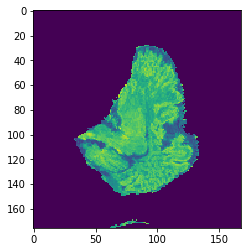

In [24]:
plt.imshow(image_data['T1'].squeeze()[80,:,:])

In [45]:
np.shape(image_data['T1'].squeeze())

(152, 176, 168)

INFO:niftynet: 

Number of subjects 16, input section names: ['subject_id', 'T1', 'T2', 'label']
-- using all subjects (without data partitioning).

INFO:niftynet: Image reader: loading 16 subjects from sections ('T1',) as input [T1]
INFO:niftynet: Image reader: loading 16 subjects from sections ('T2',) as input [T2]
INFO:niftynet: Image reader: loading 16 subjects from sections ('label',) as input [label]
INFO:niftynet: 

Number of subjects 16, input section names: ['subject_id', 'T1', 'T2', 'label']
-- using all subjects (without data partitioning).

INFO:niftynet: Image reader: loading 16 subjects from sections ('T1',) as input [T1]
INFO:niftynet: Image reader: loading 16 subjects from sections ('T2',) as input [T2]
INFO:niftynet: Image reader: loading 16 subjects from sections ('label',) as input [label]
INFO:niftynet: 

Number of subjects 16, input section names: ['subject_id', 'T1', 'T2', 'label']
-- using all subjects (without data partitioning).

INFO:niftynet: Image reader: lo

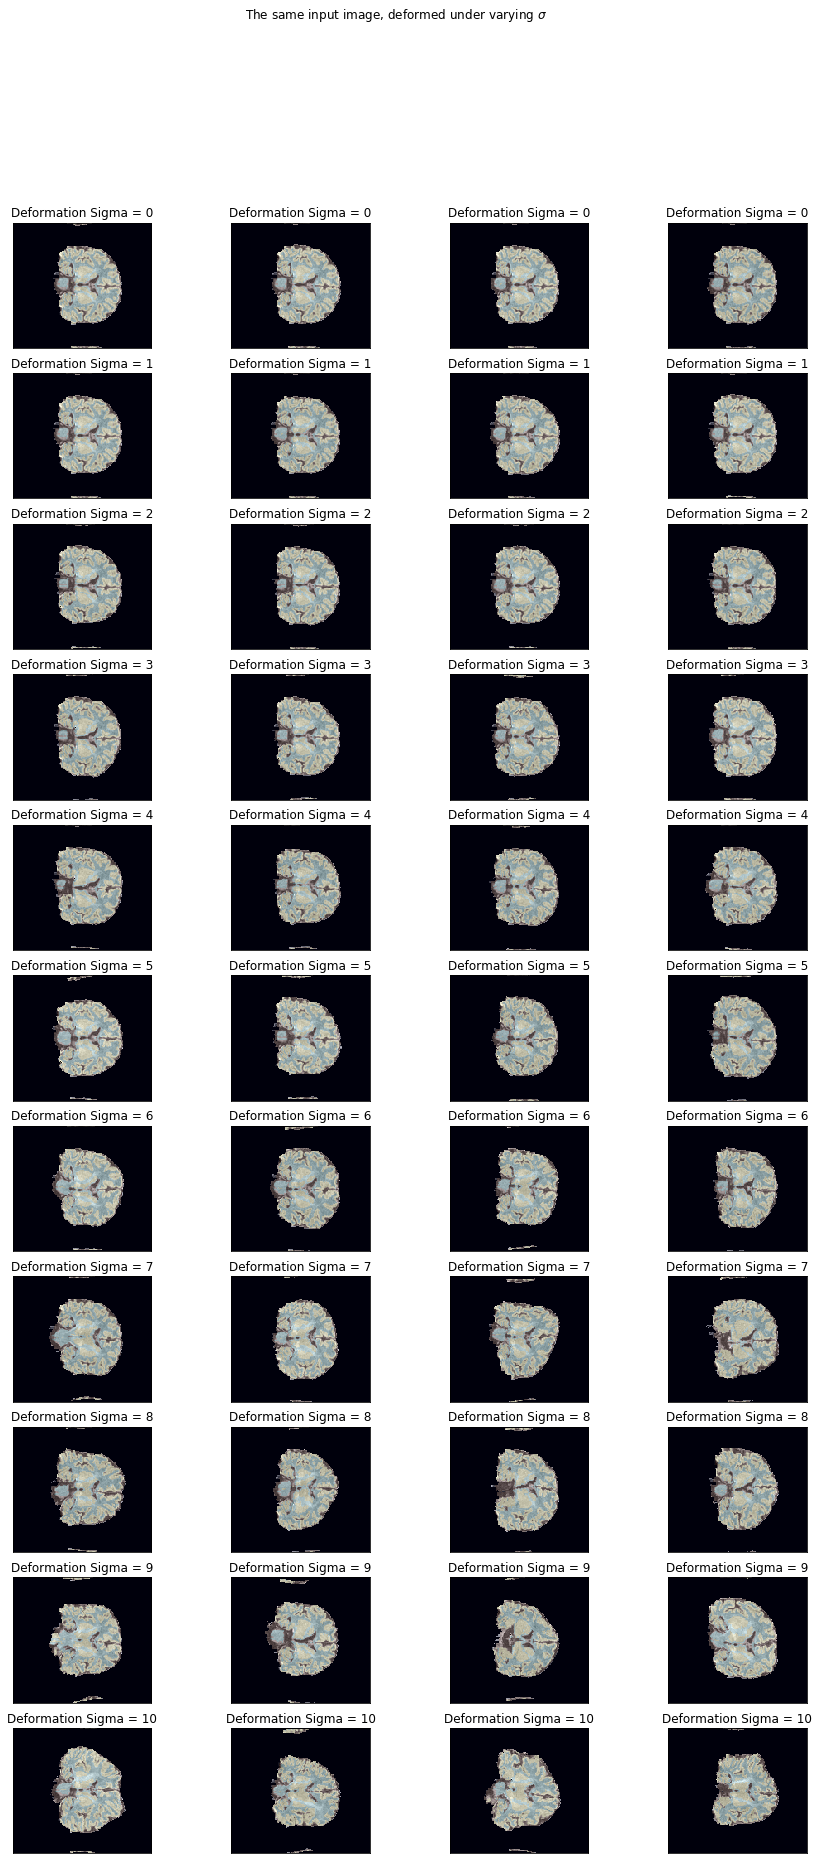

In [28]:
f, axes = plt.subplots(11,4,figsize=(15,30))
f.suptitle('The same input image, deformed under varying $\sigma$')

for i, axe in enumerate(axes): 
    std_sigma = i
    reader = create_image_reader(6, std_sigma)
    for ax in axe: 
        _, image_data, _ = reader(1)
        ax.imshow(image_data['T1'].squeeze()[:,80,:], cmap='gray')
        ax.imshow(image_data['label'].squeeze()[:,80,:], cmap='jet', alpha=0.1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('Deformation Sigma = %i' % std_sigma)


INFO:niftynet: 

Number of subjects 16, input section names: ['subject_id', 'T1', 'T2', 'label']
-- using all subjects (without data partitioning).

INFO:niftynet: Image reader: loading 16 subjects from sections ('T1',) as input [T1]
INFO:niftynet: Image reader: loading 16 subjects from sections ('T2',) as input [T2]
INFO:niftynet: Image reader: loading 16 subjects from sections ('label',) as input [label]
INFO:niftynet: 

Number of subjects 16, input section names: ['subject_id', 'T1', 'T2', 'label']
-- using all subjects (without data partitioning).

INFO:niftynet: Image reader: loading 16 subjects from sections ('T1',) as input [T1]
INFO:niftynet: Image reader: loading 16 subjects from sections ('T2',) as input [T2]
INFO:niftynet: Image reader: loading 16 subjects from sections ('label',) as input [label]
INFO:niftynet: 

Number of subjects 16, input section names: ['subject_id', 'T1', 'T2', 'label']
-- using all subjects (without data partitioning).

INFO:niftynet: Image reader: lo

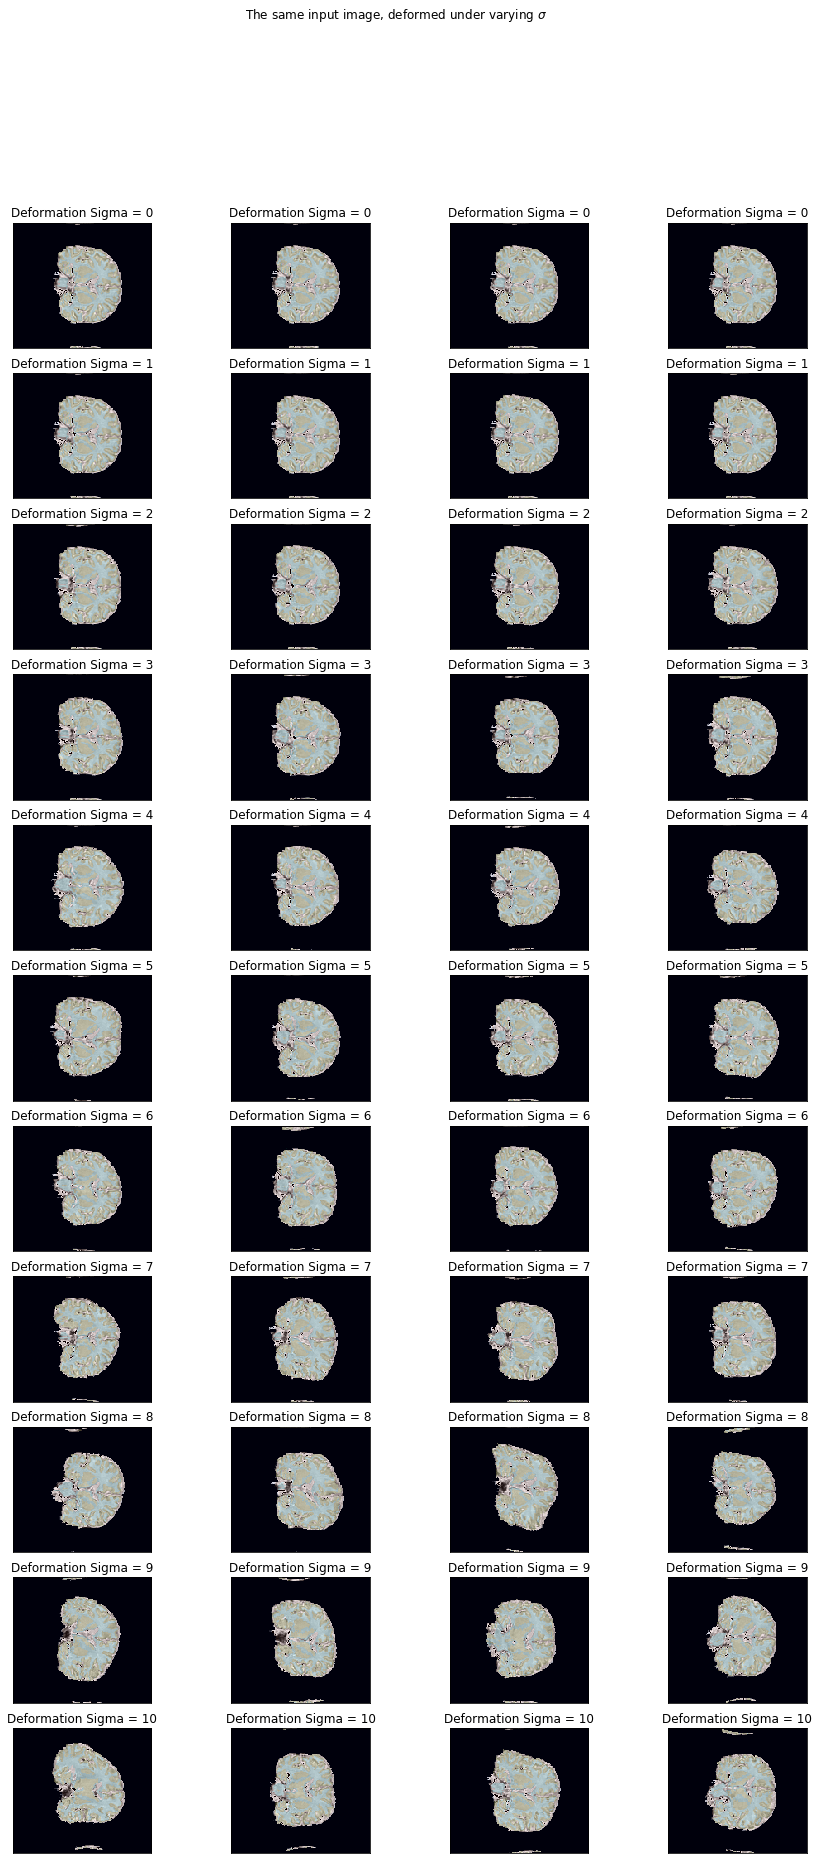

In [29]:
f, axes = plt.subplots(11,4,figsize=(15,30))
f.suptitle('The same input image, deformed under varying $\sigma$')

for i, axe in enumerate(axes): 
    std_sigma = i
    reader = create_image_reader(6, std_sigma)
    for ax in axe: 
        _, image_data, _ = reader(1)
        ax.imshow(image_data['T2'].squeeze()[:,80,:], cmap='gray')
        ax.imshow(image_data['label'].squeeze()[:,80,:], cmap='jet', alpha=0.1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('Deformation Sigma = %i' % std_sigma)

In [4]:
def sitk_imshow(im,num):
    plt.imshow(sitk.GetArrayFromImage(sitk.ReadImage(im))[num,:,:])

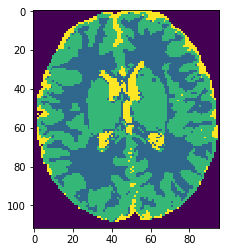

In [8]:
sitk_imshow('/proj/NIRAL/users/siyangj/myTrialData/min_normal/BUSS_2083_seg.nrrd',
           60)

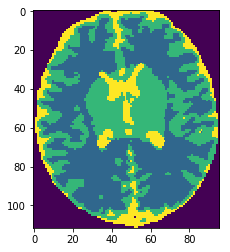

In [12]:
sitk_imshow('/proj/NIRAL/users/siyangj/myTrialData/BUSS_reg_stripped_scaled/to_inf/10112055_21900_2/BUSS_2083_.nii.gz',
           60)